In [ ]:
import os
import networkx as nx
import numpy as np
import pandas as pd
from datetime import datetime
from tqdm import tqdm
import pickle
import time
import matplotlib.pyplot as plt

**FOR MY COLLEAGUES**<br>
Ignore the part with the dataframes, skip to the last two cells (the one with the class definition and the one after that) and run those. Be sure to have downloaded the file I put on drive and put it in a folder called "files". IMO, this is preferable to changing the path in the cell because if we were to do so we would end up uploading versions with different paths at every git push.

In [15]:
def load_dfs():
    
    if "df_a2q" not in os.listdir("files") \
    or "df_c2q" not in os.listdir("files") \
    or "df_c2a" not in os.listdir("files"):
    
        file_names = ["files/sx-stackoverflow-a2q.txt",
                      "files/sx-stackoverflow-c2q.txt",
                      "files/sx-stackoverflow-c2a.txt"]

        columns = [["user_answering", 
                    "user_questioning", 
                    "time_u"],
                   ["user_commenting", 
                    "user_questioning", 
                    "time_u"],
                   ["user_commenting", 
                    "user_answering", 
                    "time_u"]]

        df_a2q_raw = pd.read_csv(file_names[0],
                                 delim_whitespace=True,
                                 names=columns[0])

        df_c2q_raw = pd.read_csv(file_names[1],
                                 delim_whitespace=True,
                                 names=columns[1])

        df_c2a_raw = pd.read_csv(file_names[2],
                                 delim_whitespace=True,
                                 names=columns[2])
        
        
        dfs_raw = [df_a2q_raw, df_c2q_raw, df_c2a_raw]

        print(df_a2q_raw.shape)

        # add a column for a standard visualization of dates
        for df in dfs_raw:
            df["time_h"] = pd.to_datetime(df["time_u"], unit="s")

        names = ["a2q", "c2q", "c2a"]
        for i, df in enumerate(dfs_raw):
            most_recent = df["time_h"].max()
            name = names[i]
            print(f"Most recent date for dataset {name}: {most_recent}")

        threshold = datetime(year=2014, month=1, day=1, hour=0, minute=0, second=0)
        print(f"Date threshold selected: {threshold}")

        df_a2q = df_a2q_raw[df_a2q_raw["time_h"] > threshold].copy()
        df_c2q = df_c2q_raw[df_c2q_raw["time_h"] > threshold].copy()
        df_c2a = df_c2a_raw[df_c2a_raw["time_h"] > threshold].copy()

        dfs = [df_a2q, df_c2q, df_c2a]
        for df in dfs:
            min_el = df["time_u"].min()
            max_el = df["time_u"].max()
            
            # variation on min max scaler so to have values closer to the max -> to 0 and values
            # closer to the min -> to 1.
            df["weight"] = (max_el - df["time_u"]) / (max_el - min_el)
            
            df.drop("time_u", inplace=True, axis=1)

        with open("files/df_a2q", "wb") as file:
            pickle.dump(df_a2q, file)

        with open("files/df_c2q", "wb") as file:
            pickle.dump(df_c2q, file)

        with open("files/df_c2a", "wb") as file:
            pickle.dump(df_c2a, file)
    
    else:
        
        with open("files/df_a2q", "rb") as file:
            df_a2q = pickle.load(file)
        
        with open("files/df_c2q", "rb") as file:
            df_c2q = pickle.load(file)
            
        with open("files/df_c2a", "rb") as file:
            df_c2a = pickle.load(file)
    
    return df_a2q, df_c2q, df_c2a

In [16]:
names = ["a2q", "c2q", "c2a"]

In [17]:
df_a2q, df_c2q, df_c2a = load_dfs()
print(df_a2q.shape)

(6962095, 4)


In [18]:
df_a2q.head()

user_answering  user_questioning              time_h  weight
10861428           95190            960750 2014-01-01 00:00:05     1.0
10861429          607314           2635650 2014-01-01 00:00:12     1.0
10861430          301857           1549201 2014-01-01 00:00:16     1.0
10861431         1419954           1897577 2014-01-01 00:00:21     1.0
10861432          254252           3065375 2014-01-01 00:00:23     1.0

In [19]:
df_c2q.head()

user_commenting  user_questioning              time_h  weight
9576868           976391           3061211 2014-01-01 00:00:08     1.0
9576869           445131           2489834 2014-01-01 00:00:24     1.0
9576870          1832636           2721870 2014-01-01 00:00:27     1.0
9576871           822711           3136232 2014-01-01 00:00:28     1.0
9576872            22656           1693074 2014-01-01 00:00:34     1.0

In [20]:
df_c2a.head()

user_commenting  user_answering              time_h  weight
14958295            22656           22656 2014-01-01 00:00:08     1.0
14958296          2224701           23385 2014-01-01 00:00:14     1.0
14958297          2732801         2732801 2014-01-01 00:00:21     1.0
14958298          1965449         2325987 2014-01-01 00:00:22     1.0
14958299            26742           26742 2014-01-01 00:00:23     1.0

In [21]:
dfs = [df_a2q,
       df_c2q,
       df_c2a]

In [3]:
def time_wrapper(func):
    """
    Decorator to time functions, probably we won't need it in the final version, but for now I'm leaving it 
    in case you need it too. Just put @time_wrapper above any function you want to time and it will print
    the time in seconds it took to run.
    """
    def wrapped(*args, **kwargs):
        start = time.time()
        r = func(*args, **kwargs)
        print(f"Time elapsed: {time.time()-start}")
        return r
    return wrapped


def visualize_network(graph, edges_to_highlight=[], highlight_nodes=True):
    
    nx_g = nx.MultiGraph(graph)
    black_edges = [edge for edge in nx_g.edges() if edge not in edges_to_highlight]
    nodes_to_highlight=[]
    if highlight_nodes:
        for edge in edges_to_highlight:
            for node in edge:
                if node not in nodes_to_highlight:
                    nodes_to_highlight.append(node)
        blank_nodes = [node for node in nx_g.nodes() if node not in nodes_to_highlight]
    
    plt.figure(figsize=(30, 20))
    pos = nx.spring_layout(nx_g)
    
    nx.draw_networkx_nodes(nx_g, pos, cmap=plt.get_cmap('jet'), node_size = 100, nodelist=nodes_to_highlight, node_color="r")
    nx.draw_networkx_nodes(nx_g, pos, cmap=plt.get_cmap('jet'), node_size = 100, nodelist=blank_nodes, alpha=0.2)
    nx.draw_networkx_edges(nx_g, pos, edgelist=edges_to_highlight, edge_color='r', arrows=True)
    nx.draw_networkx_edges(nx_g, pos, edgelist=black_edges, alpha=0.2, arrows=True)
    plt.show()


class Graph:
    
    def __init__(self):
        self.graph = {}
                
    
    @time_wrapper
    def create_graph(self, sources, names):
        """
        Args:
            sources: dataframes from which to create the graph
            names: a list of string containing the names of the graph used in order to label the edges accordingly
        
        Summary:
            Each node in the graph acts as a key in the dictionary self.graph. Each entry in the dictionary is itself
            another dictionary, indexed by that node's neighbors and pointing to a list with the details of that edge,
            specifically [type_of_interaction, weight, date_human_format].
            So to make things clearer:
            
            self.graph -> Our entire graph, indexed by node
            self.graph[node "A"] -> dictionary indexed by the neighbors of "A"
            self.graph[node "A"][node "B"] -> dictionary indexed by the time the interation took place
            self.graph[node "A"][node "B"][time "x"] -> details (specifically type of interaction and edge weight) of the
                                                        of the interaction between user A and B that took place at time x            
        """
        
        self.graph = {}
    
        for i_source, source in enumerate(sources):
            nodes_column = source.iloc[:, 0]
            nodes = nodes_column.unique()
            type_of_interaction = names[i_source]
            
            for node in tqdm(nodes):
                if node not in self.graph.keys():
                    self.graph[node] = {}
                node_subdf = source[nodes_column == node]
                neighbors = node_subdf.iloc[:, 1].values
                times_h = node_subdf.iloc[:, 2].values
                weights = node_subdf.iloc[:, 3].values
                for i, neighbor in enumerate(neighbors):
                    if neighbor not in self.graph.keys(): # here we want to make sure that if we're working on a subset
                                                          # of data we still obtain a coherent graph. Otherwise we may
                                                          # end up with neighbors that don't exist as actual nodes
                                                          # in our graph.
                        self.graph[neighbor] = {}
                    if neighbor not in self.graph[node].keys():
                        self.graph[node][neighbor] = {}
                        
                    self.graph[node][neighbor][times_h[i]] = {"weight": weights[i], 
                                                              "type_of_interaction": type_of_interaction}
        
    
    @time_wrapper
    def save_graph(self, path):
        """
        Args:
            path: name of file where we want the file stored
        Summary:
            Saves graph as a binary file.
        """
        
        with open(path, "wb") as file:
            pickle.dump(self.graph, file)

    
    @time_wrapper
    def load_graph(self, path):
        """
        Args:
            path: name of file to load the graph from.
        Summary:
            Load graph from binary file.
        """
        
        with open(path, "rb") as file:
            self.graph = pickle.load(file)
    
    
    def get_random_subgraph(self, n_nodes=10000):
        np.random.seed(42)
        bad_starting_node = True
        while bad_starting_node:
            random_node = np.random.choice(list(self.graph.keys()))
            if len(self.graph[random_node].keys()) > 10:
                bad_starting_node = False
        print(random_node)
        print(len(self.graph[random_node].keys()))
        subgraph = {random_node: {}}
        to_check = [random_node]
        i = 0
        
        while len(subgraph.keys()) < n_nodes:
            node = to_check[i]
            if node not in subgraph.keys() or len(subgraph[node].keys()) < 1:
                for neighbor in self.graph[node].keys():
                    if neighbor not in to_check:
                        to_check.append(neighbor)
                    if neighbor not in subgraph.keys():
                        subgraph[neighbor] = {}
                    subgraph[node][neighbor] = self.graph[node][neighbor]
                    if len(subgraph.keys()) >= n_nodes:
                        break
            i += 1
        
        return subgraph
    
    
    def dijkstra(self, start_node, end_node, gr, visualization=True):
        unvisited = []
        for key in gr.keys():
            if key not in unvisited:
                unvisited.append(key)
        visited = []
        
        min_distances = {key: (np.inf, None) for key in gr.keys()}
        min_distances[start_node] = (0, None)
        
        current_node = start_node
        
        while current_node != end_node:
            visited.append(current_node)
            unvisited.remove(current_node)
            for neighbor in gr[current_node].keys():
                weights = [gr[current_node][neighbor][time_key]["weight"] for time_key in gr[current_node][neighbor].keys()]
                weight = np.min(weights)
                tot = min_distances[current_node][0] + weight
                if tot < min_distances[neighbor][0]:
                    min_distances[neighbor] = (tot, current_node)
            
            min_unvisited = np.inf
            found_something = False
            for candidate in unvisited:
                if min_distances[candidate][0] < min_unvisited:
                    min_unvisited = min_distances[candidate][0]
                    current_node = candidate
                    found_something = True
            
            if not found_something:
                break
        
        node_a = None
        node_b = end_node
        
        path = []
        while node_a != start_node:
            node_a = min_distances[node_b][1]
            if node_a == None:
                break
            path.append((node_a, node_b))
            node_b = node_a
        
        if len(path) <= 0:
            print("No path found.")
        
        else:
            path = path[::-1]
            if visualization:
                visualize_network(gr, path)
        
        return path, min_distances
    
    
    @time_wrapper
    def get_neighbors(self, node, interaction="all"):
        """
        Args:
            node: the node we want the neighbors of.
            interaction: the label of the edges we're interested in, default=all, meaning we will obtain all
                         neighbors of that node, regardless of the type of interactions.
        Summary:
            Obtains all the neighbors of a specific node.
        """
        
        if interaction == "all":
            neighbors = list(self.graph[node].keys())
        else:
            neighbors = []
            for neighbor in self.graph[node].keys():
                if self.graph[node][neighbor][0] == interaction:
                    neighbors.append(neighbor)
        
        return neighbors
        

In [ ]:
# Before running this cell, make sure to have the pickle file in a "files" folder, or change the path of the if 
# condition accordingly. This will take some time: on my pc it takes approximately 7 minutes to load the graph.
# The timing decorator will tell you how much it took, so you can plan accordingly.

g = Graph()

if "merged_graph.p" in os.listdir("files"):
    g.load_graph("files/merged_graph.p")
else:
    g.create_graph(dfs, names=names)
    g.save_graph("files/merged_graph.p")

In [5]:
subg = g.get_random_subgraph(n_nodes=1000)

1750757
385


In [6]:
np.random.choice(list(subg.keys()), 2)

array([4594973,  613004])

In [8]:
#1491895
for key in subg[1750757].keys():
    if len(list(subg[key].keys())) > 3:
        print(key)

1750757
2953119
3097348
3345972
981959


In [ ]:
subg[596952].keys()

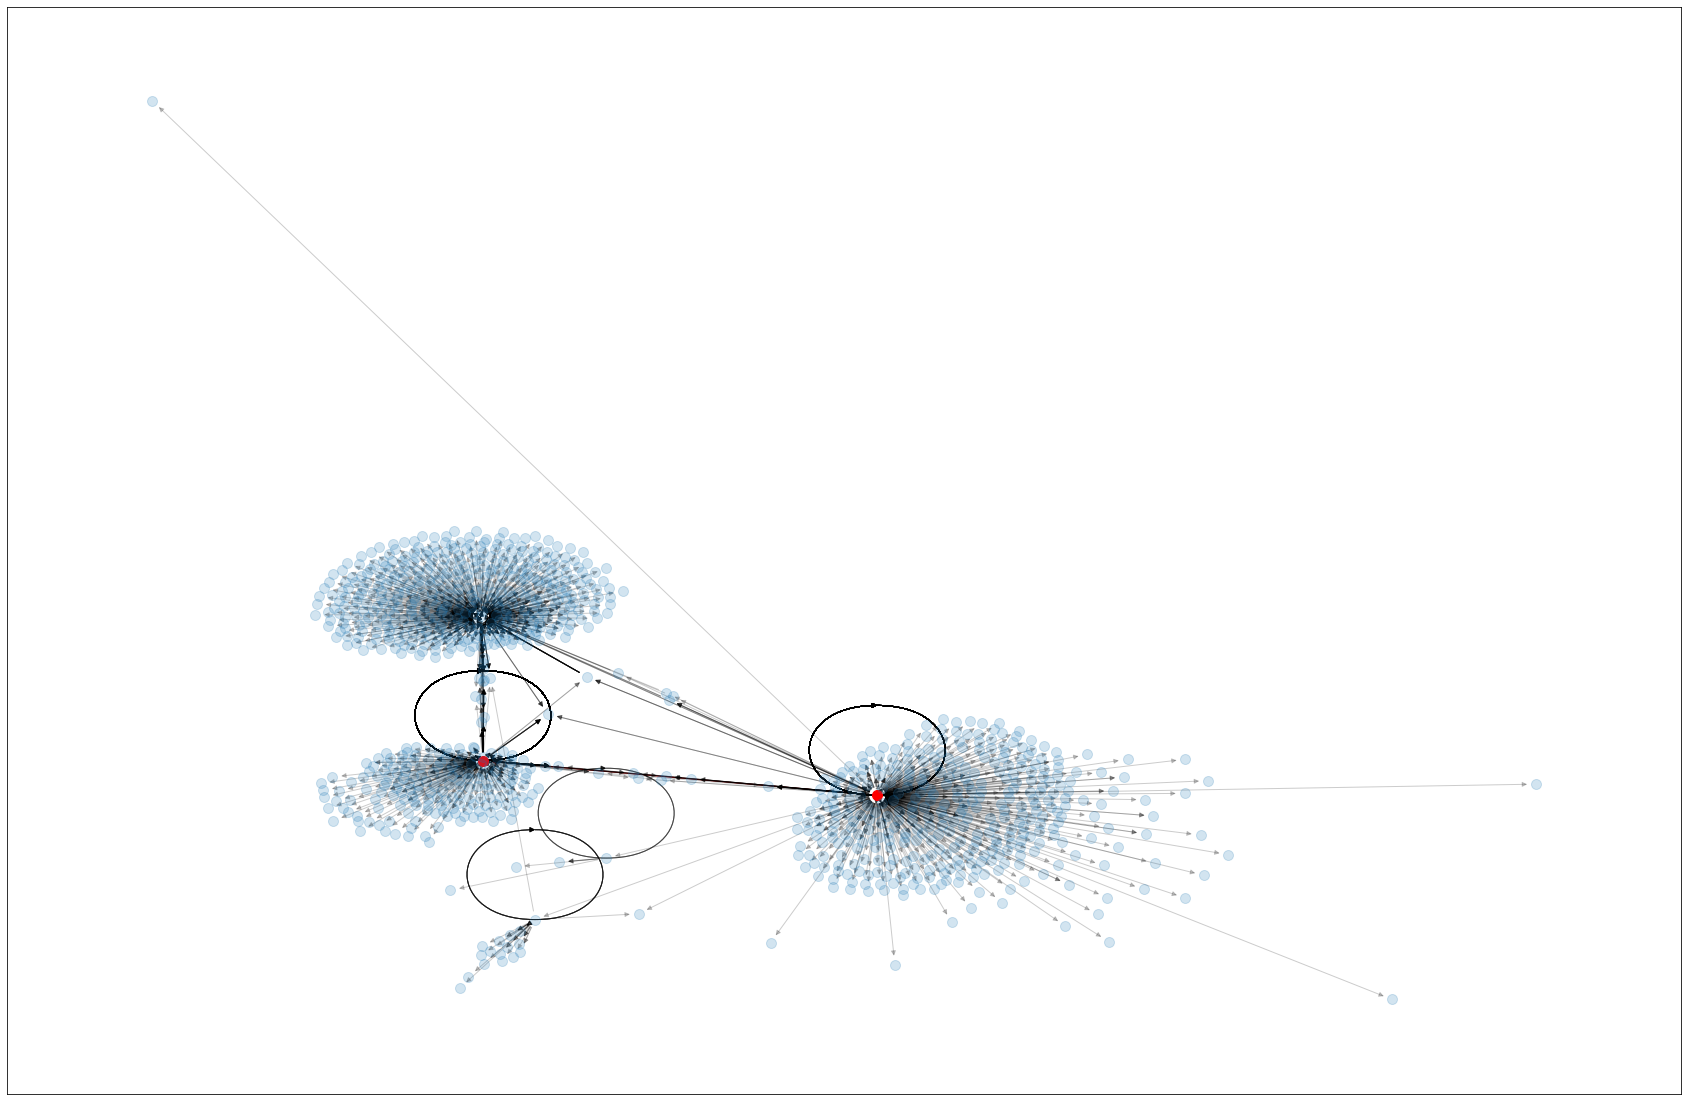

([(1750757, 2953119)],
 {1750757: (0, None),
  3186758: (0.9827520073244179, 1750757),
  2474791: (0.9814837387633597, 1750757),
  620029: (0.9714516123775772, 1750757),
  2708741: (0.9640348070473079, 1750757),
  2057056: (0.9485662728389204, 1750757),
  442124: (0.8997468991574964, 1750757),
  1594994: (0.5877079924940081, 1750757),
  2104682: (0.5852441868369055, 1750757),
  4283953: (0.571261093476184, 1750757),
  3198842: (0.5690204434922929, 1750757),
  283296: (0.5683878150542581, 1750757),
  2180836: (0.5679317557419302, 1750757),
  4347793: (0.5671488631369291, 1750757),
  1662988: (0.566456539319628, 1750757),
  4359124: (0.5628387345405991, 1750757),
  3456472: (0.5063016380307317, 1750757),
  2158231: (0.5122788433872593, 1750757),
  4086712: (0.5101750577545157, 1750757),
  3319454: (0.5063368907492211, 1750757),
  841330: (0.32004637249701845, 1750757),
  4262074: (0.5044800632855405, 1750757),
  4510291: (0.5039685715103795, 1750757),
  1611963: (0.5034938892184122, 1750

In [12]:
g.dijkstra(start_node=1750757,
           end_node=2953119,
           gr=subg)

In [ ]:
visualize_network(subg)

In [4]:
# This for lightweight graph

g = Graph()
g.load_graph("files/merged_graph_lw_2.p")

Time elapsed: 1.3236327171325684


In [ ]:
df_a2q.head()

In [ ]:
visualize_network(g)

## Functionality 2

In [ ]:
def selecttime(gr, time: tuple):
    """
    Selects a subgraph that whose entries are within the time interval
    :param gr:       initial graph
    :param time:     tuple (start time, end time) in yyyy-mm-dd format
    :returns:        subgraph whose edges are in the time interval
    """
    for key in list(gr.graph.keys()):
        for stuff in list(gr.graph[key].keys()): ## gr.get_neighbors(key)
            for tup in gr.graph[key][stuff]:
                timegraph = str(tup[2])
                truetime = datetime.strptime(timegraph[:10], "%Y-%m-%d")
                start = datetime.strptime(time[0], "%Y-%m-%d")
                end = datetime.strptime(time[1], "%Y-%m-%d")
                if not (truetime > start and truetime < end):
                    gr.graph[key][stuff].remove(tup)
            if gr.graph[key][stuff] == []:
                gr.graph[key].pop(stuff)
        if gr.graph[key] == []:
            gr.graph.pop(key)
    return gr

def matrixfromgraph(gr):
    """
    Creates adjacency matrix normalized over rows
    :param:       graph
    :returns:     adjacency matrix normalized over rows
    """
    keys = list(gr.graph.keys())
    ris = np.zeros((len(keys), len(keys)))
    for i in range(len(keys)):
        for j in range(len(keys)):
            if keys[j] in gr.graph[keys[i]]:
                for tup in gr.graph[keys[i]][keys[j]]:
                    ris[i][j] += tup[1]
        if np.sum(ris[i]):
            ris[i] /= np.sum(ris[i])
    return ris

def shortlength(gr, start, end):
    """
    finds the shortest path from one node to another using a mechanism similar to dijsktra's algorithm 
    keeping info on the nodes that lead to the path
    :param gr:      graph
    :param start:   starting node
    :param end:     end node
    :returns:       list of ordered nodes in the shortest path
    
    """
    dic = distances(gr, start)
    path = []
    current = end
    while current is not None:
        path.append(current)
        if current in dic.keys():
            app = dic[current][0]
            current = app
        else:   
            # returns empty list if path does not exist
            # (it should, since we are considering cc of the graph)
            print('Attention')
            return [] 
    path = path[::-1]
    return path

def component(gr, node):
    """ 
    Returns the connected component of the graph gr that contains the node 
    (if edges spawn from it)
    :param gr: the graph
    :param node: the node that we are interested in
    :returns 
    """
    ris = Graph()
    vis = set()
    current = node
    to_do = {i for i in gr.get_neighbors(node)}
    while len(to_do):
        vis.add(current)
        if current in gr.graph.keys():
            ris.graph[current] = {}
            for edge in gr.graph[current].keys():
                ris.graph[current][edge] = gr.graph[current][edge]
                if edge not in vis:
                    to_do.add(edge)
        current = to_do.pop()
    return ris
  
def distances(gr, start):
    """
    Returns a dictionary whose values indicate the total distance from the starting
    node and the node that precedes them in the shortest path
    :param gr:     the graph that is being considered
    :param start:  the starting node
    :returns:      dictionary in the form dic[key] = (preceding_node, start-key distance)
    """
    dic = {start: (None, 0)} #in this dictionary the node is the key and the value is a tuple
    # made of the node that leads to this node and the total distance from the stating point
    current = start
    vis = set()
    i = 0
    while True:
        # print(i)
        i += 1
        vis.add(current)
        if current in gr.graph.keys():
            neighbors = gr.get_neighbors(current)
            len_so_far = dic[current][1]
            for node in neighbors:
                newweight = min([tup[1] for tup in gr.graph[current][node]])
                weight = newweight + len_so_far
                if node not in dic:
                    dic[node] = (current, weight)
                else:
                    current_shortest_weight = dic[node][1]
                    if current_shortest_weight > weight:
                        dic[node] = (current, weight)      
            new = {node: dic[node] for node in dic if node not in vis}
        else:
            new.pop(current)
        if not new:
                return dic
        current = min(new, key=lambda k: new[k][1])

In [ ]:
def functionality_2(user: int, time: tuple, metric: str):
    gtime = component(g, user)
    gtime = selecttime(gtime, time)
    gtime = component(gtime, user)
    keylist = list(gtime.graph.keys())
    lenlist = len(keylist)
    if metric == 'Betweenness':
        ris = -1
        dicuser = distances(gtime, user)
        for i in tqdm(selecttime(g, time).graph.keys()):
            diclen = distances(component(selecttime(g, time), i), i)
            if user in diclen.keys():
                for j in set(diclen.keys() and dicuser.keys()):
                    if diclen[j][1] == diclen[user][1] + dicuser[j][1]:
                        ris += 1
        lenlist = len(selecttime(g, time).graph.keys())
        tot = (lenlist ** 2 - lenlist)
        if tot == 0:
            return 'There is a problem'
        return ris/tot
    if metric == 'PageRank':
        M = matrixfromgraph(gtime)
        vec = np.ones((M.shape[1], 1))/M.shape[1]
        vec = vec
        M2 = .85 * M + .15 / M.shape[1]
        for _ in range(50):
            vec = M2 @ vec
        return vec
    if metric == 'ClosenessCentrality':
        ris = distances(gtime, user)
        dist = np.sum([ris[j][1] for j in ris.keys()])
        if dist == 0:
            return 'There is a problem'
        return (lenlist - 1)/dist
    if metric == 'DegreeCentrality':
        ris = 0
        for i in gtime.graph[user].keys():
            for t in gtime.graph[user][i]:
                ris += 1
        return ris

## Functionality 4 (Work in progress)

In [13]:
def get_df_for_time_interval(start, end, dfs, names):
    
    start = datetime.strptime(start, "%d %B %Y %H:%M:%S")
    end = datetime.strptime(end, "%d %B %Y %H:%M:%S")
    print(f"start: {start}")
    print(f"end: {end}")
    
    subdfs = []
    
    for i, df in enumerate(dfs):
        sub_df = df[df["time_h"] >= start]
        sub_df = sub_df[sub_df["time_h"] < end]
        sub_df.columns = ["user_a", "user_b", "time_h", "weight"]
        sub_df["type"] = names[i]
        subdfs.append(sub_df)
    
    return pd.concat(subdfs, axis=0)

In [22]:
start_1 = "10 June 2015 15:00:00"
end_1 = "10 June 2015 19:00:00"

df_g1 = get_df_for_time_interval(start_1, end_1, dfs, names)

start: 2015-06-10 15:00:00
end: 2015-06-10 19:00:00


In [23]:
df_g1.head()

user_a   user_b              time_h    weight type
15460575   142637  1458985 2015-06-10 15:00:00  0.339263  a2q
15460576  1498493   208348 2015-06-10 15:00:01  0.339263  a2q
15460577    15541  4757175 2015-06-10 15:00:05  0.339263  a2q
15460578   539121  1511832 2015-06-10 15:00:06  0.339262  a2q
15460579  3347365  2182358 2015-06-10 15:00:23  0.339262  a2q

In [24]:
def get_subgraph_from_df(df):
    subg = {}
    nodes = np.unique(df["user_a"].values)
    for node in nodes:
        
        if node not in subg.keys():
            subg[node] = {}
        
        subdf = df[df["user_a"]==node]
        neighs = subdf["user_b"].values
        times = subdf["time_h"].values
        weights = subdf["weight"].values
        type_of_interaction = subdf["type"].values
        
        for i, neigh in enumerate(neighs):
            if neigh not in subg.keys():
                subg[neigh] = {}
            if neigh not in subg[node].keys():
                subg[node][neigh] = {}
            subg[node][neigh][times[i]] = {"weight": weights[i], 
                                           "type_of_interaction": type_of_interaction[i]}
        
    return subg

In [64]:
@time_wrapper
def disconnect_nodes(subg, node_1, node_2):
    
    removed_edges = []
    shortest_path = [node_1]
    shortest_path, distances_m = g.dijkstra(start_node=node_1, end_node=node_2, gr=subg, visualization=False)
    
    while len(shortest_path) > 0:
        print(shortest_path)
        cheapest_value = np.inf
        candidate_edge = (None, None)
        
        node_b = node_2
        
        while node_b != node_1:
            value, node_a = distances_m[node_b]
            if value < cheapest_value:
                candidate_edge = (key, node_b)
            node_b = node_a
                
        removed_edges.append(candidate_edge)
        subg[candidate_edge[0]].pop(candidate_edge[1])
        
        shortest_path, distances_m = g.dijkstra(start_node=node_1, end_node=node_2, gr=subg, visualization=False)
    
    return removed_edges

In [26]:
subg_1 = get_subgraph_from_df(df=df_g1)

In [55]:
len(subg_1.keys())

6983

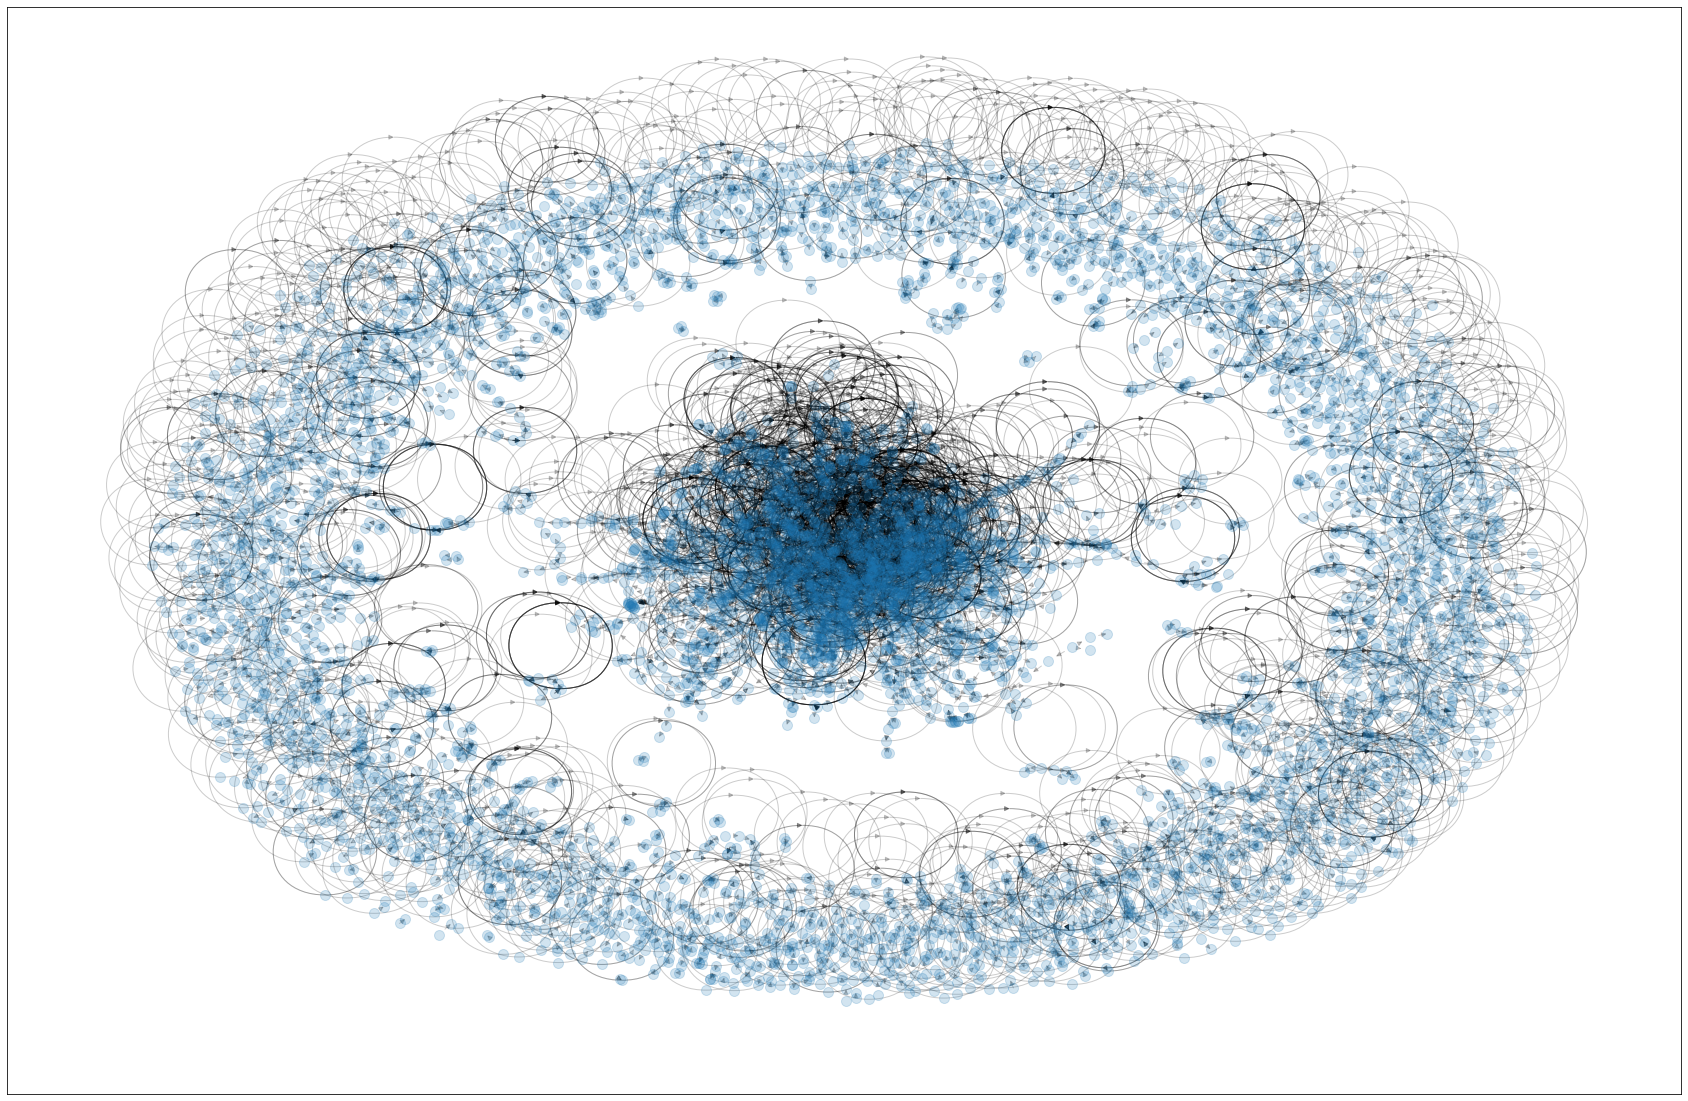

In [27]:
visualize_network(subg_1)

In [68]:
def find_good_nodes(gr):

    for key in gr.keys():
        if len(gr[key].keys()) > 3:
            for key_2 in gr[key].keys():
                if len(gr[key_2].keys()) > 2:
                    print(key, key_2)
                    return
    

In [69]:
find_good_nodes(subg_1)

267 2279448


In [71]:
subg_1[2279448]

{1831530: {numpy.datetime64('2015-06-10T15:32:31.000000000'): {'weight': 0.3392341893230733,
   'type_of_interaction': 'a2q'}},
 13552: {numpy.datetime64('2015-06-10T15:58:34.000000000'): {'weight': 0.33921144891902916,
   'type_of_interaction': 'a2q'}},
 91414: {numpy.datetime64('2015-06-10T16:13:29.000000000'): {'weight': 0.33919842738248435,
   'type_of_interaction': 'a2q'}},
 514329: {numpy.datetime64('2015-06-10T16:59:05.000000000'): {'weight': 0.3391586207635049,
   'type_of_interaction': 'a2q'}},
 2279448: {numpy.datetime64('2015-06-10T15:34:34.000000000'): {'weight': 0.33929707921900304,
   'type_of_interaction': 'c2a'}}}

In [72]:
to_remove = disconnect_nodes(subg_1, 267, 1831530)

[(267, 1831530)]
[(267, 2279448), (2279448, 1831530)]
No path found.
Time elapsed: 1.247086763381958


In [73]:
to_remove

[(267, 1831530), (267, 2279448)]

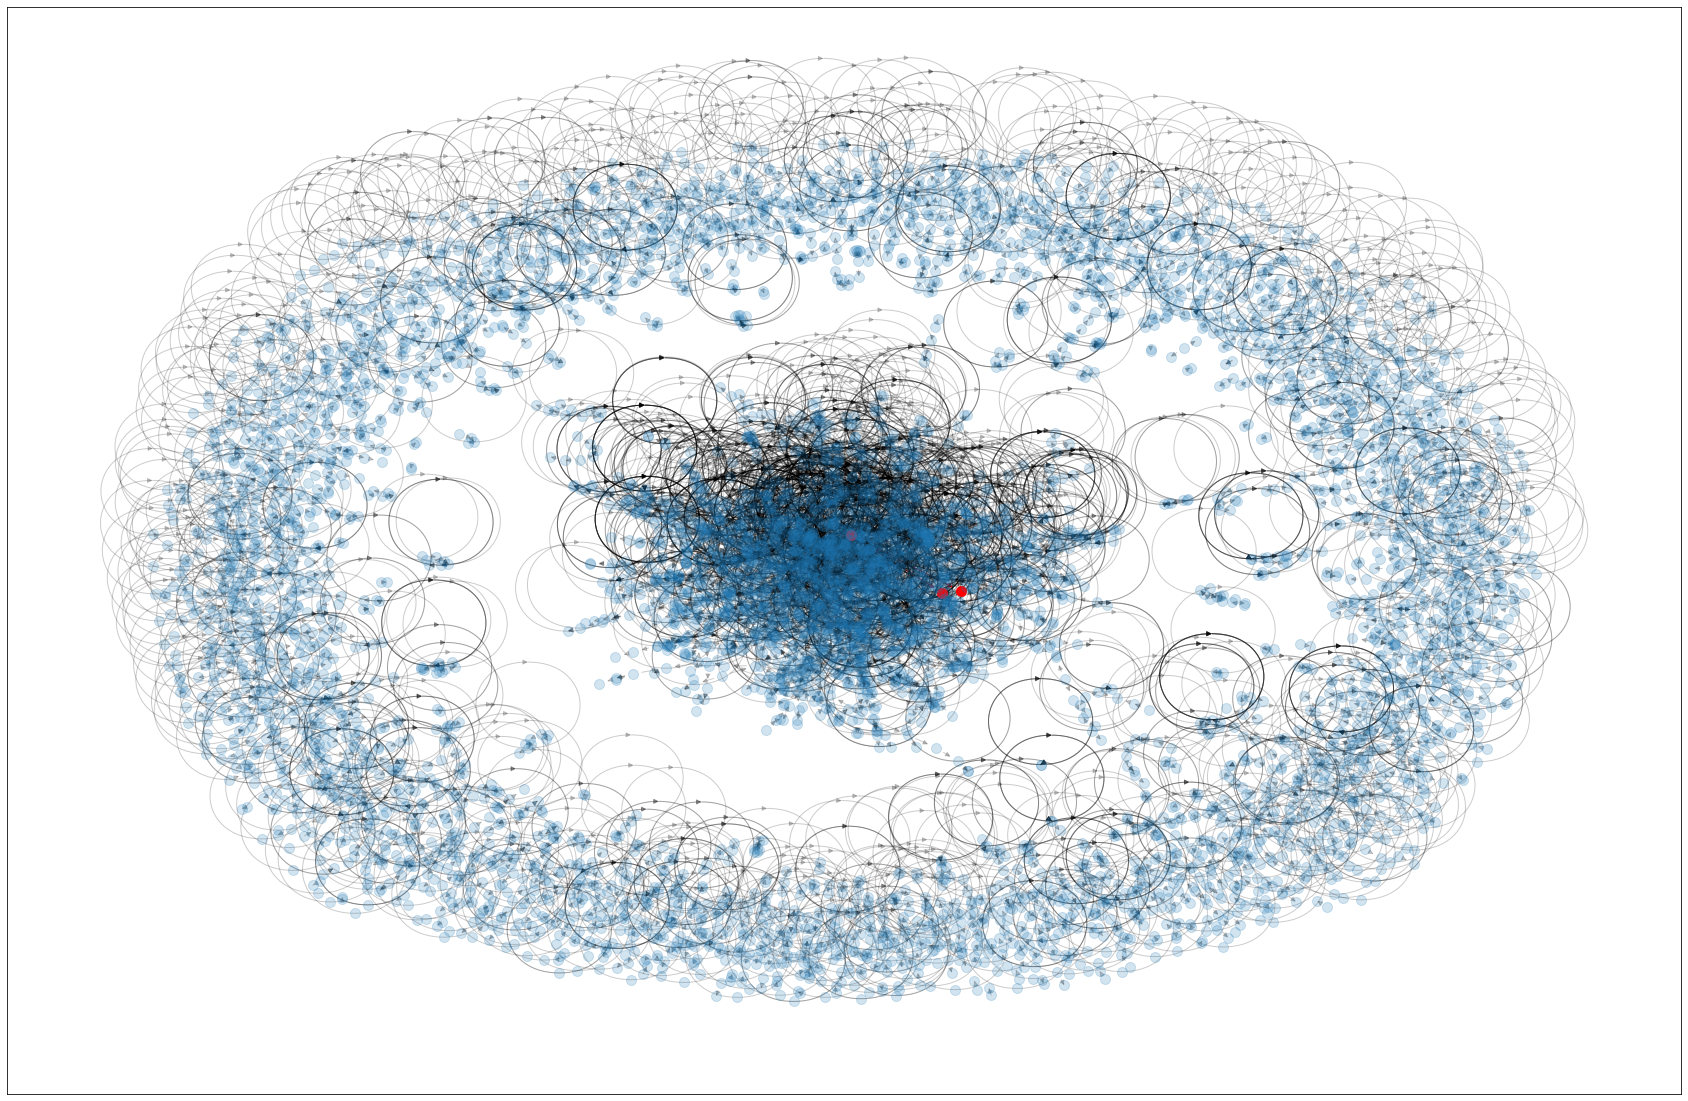

In [74]:
visualize_network(subg_1, to_remove)

In [56]:
nx_g = nx.MultiGraph(subg_1)
nx_g.number_of_nodes()

6983

In [ ]:
visualize_network(subg_1)

In [ ]:
df_g1.shape

In [ ]:
len(subg_1.keys())